In [1]:
import itertools 
import numpy as np
import matplotlib.pyplot as plt
import pickle
import dataclasses
import numpy as np

@dataclasses.dataclass
class BenchmarkResult:
    mean_time: float
    median_time: float
    p90_time: float
    num_samples: int
    mem_gb: float
    utilization: float

def is_small_and_monotonic_decreasing(arr):
    arr = np.array(arr)
    return np.prod(arr) <= 64 and np.all(arr[:-1] >= arr[1:])


def generate_expansion_configs(): 
    k_1_values = np.array([1, 2, 4, 8, 16, 32]) 
    k_2_values = np.array([1, 2]) 
    remaining_k_i_values = np.array([1]) 
    all_configs = [] 
    for length in [2, 3, 4, 8, 16, 32]:
        all_configs.extend( 
            list( 
                itertools.product( 
                    k_1_values, 
                    k_2_values, 
                    *[remaining_k_i_values for _ in range(length - 2)], 
                ) 
            ) 
        ) 
    return list(filter(is_small_and_monotonic_decreasing, all_configs))

In [63]:
expansion_configs = generate_expansion_configs()
kv_sizes = [0, 4, 8, 16, 64, 128]

def construct_data_dict(seq_dict, tree_dict, which_attr, cap):
    data_dict = {}
    for config in expansion_configs:
        data_dict[str(config)] = []
        for kv_size in kv_sizes:
            overall_conf = str(config) + ", " + str(kv_size)
            assert overall_conf in seq_dict
            diff = getattr(seq_dict[overall_conf], which_attr) - getattr(tree_dict[overall_conf], which_attr)
            # if (diff < 0):
            #     print(overall_conf)
            diff = np.clip(diff, -cap, cap)
            if 'time' in which_attr:
                diff = diff * 1000 # convert to ms
            else:
                assert 'mem' in which_attr
            data_dict[str(config)].append(diff)
            
    return data_dict

In [64]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.gridspec import GridSpec

def construct_graphs(seq_dict, seq_flash_dict, tree_dict, which_attr, cap, model_name):
    data_dict = construct_data_dict(seq_dict, tree_dict, which_attr=which_attr, cap=cap)
    no_flash_data = np.array(list(data_dict.values())).T
    
    if seq_flash_dict:
        flash_data_dict = construct_data_dict(seq_flash_dict, tree_dict, which_attr=which_attr, cap=cap)
        flash_data = np.array(list(flash_data_dict.values())).T
    
    if which_attr == 'median_time':
        label = 'Median Latency (ms)'
    elif which_attr == 'mem_gb':
        label = 'Max. Memory Allocation (GB)'
    elif which_attr == 'p90_time':
        label = 'P90 Latency (ms)'
    else:
        raise ValueError(f'Invalid which_attr: {which_attr}')

    # Create the heat map
    fig_height = 8 if seq_flash_dict else 4
    fig = plt.figure(figsize=(24, fig_height))
    grid_spec_count = 2 if seq_flash_dict else 1
    gs = GridSpec(grid_spec_count, 1, height_ratios=[1] * grid_spec_count, hspace=0.5)

    # Plot the first heatmap
    ax1 = fig.add_subplot(gs[0])
    vmax = min(cap * 1000 if 'time' in which_attr else 1, np.max(np.abs(no_flash_data)))

    im1 = ax1.matshow(no_flash_data, cmap='coolwarm', aspect='auto', clim=(-vmax, vmax))
    ax1_title = f'{model_name} Sequential vs. Tree {label} Difference'
    if seq_flash_dict:
        ax1_title += ' (Sequential Flash Attention Disabled)'
    ax1.set_title(ax1_title, fontsize=16)
    ax1.set_ylabel('KV Cache Token Count')

    if seq_flash_dict:
        # Plot the second heatmap
        ax2 = fig.add_subplot(gs[1])
        im2 = ax2.matshow(flash_data, cmap='coolwarm', aspect='auto', clim=(-vmax, vmax))
        ax2.set_title(f'{model_name} Sequential vs. Tree {label} Difference (Sequential Flash Attention Enabled)', fontsize=16)
        ax2.set_ylabel('KV Cache Token Count')

    axes = [ax1] + ([ax2] if seq_flash_dict else [])
    colorbar = fig.colorbar(im1, ax=axes, orientation='vertical')
    colorbar.set_label(f'Sequential {label} - Tree {label}', fontsize=12)
    
    # # Increase colorbar font size
    colorbar.ax.locator_params(nbins=10)

    # # Set x and y axis ticks and labels
    ax1.set_xticks(np.arange(len(data_dict.keys())))
    x_labels = []
    for key in data_dict.keys():
        config = key.split(", ")
        if len(config) < 8:
            x_labels.append(key)
        else:
            if '2' in config[1]:
                new_label = config[0] + ", 2, 1 X " + str(len(config) - 2) + ")"
            else:
                new_label = config[0] + ", 1, 1 X " + str(len(config) - 2) + ")"
            x_labels.append(new_label)
    ax1.set_xticklabels(x_labels, rotation=90)
    ax1.xaxis.tick_top()
    ax1.set_yticks(np.arange(len(kv_sizes)))
    ax1.set_yticklabels(kv_sizes)
    if seq_flash_dict:
        ax2.set_yticks(np.arange(len(kv_sizes)))
        ax2.set_yticklabels(kv_sizes)
        ax2.xaxis.tick_top()
        ax2.set_xticks(np.arange(len(data_dict.keys())), labels=['' for _ in range(len(data_dict.keys()))])
    
    # Add labels and title
    plt.savefig(f'{model_name}_{which_attr}_heatmap.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

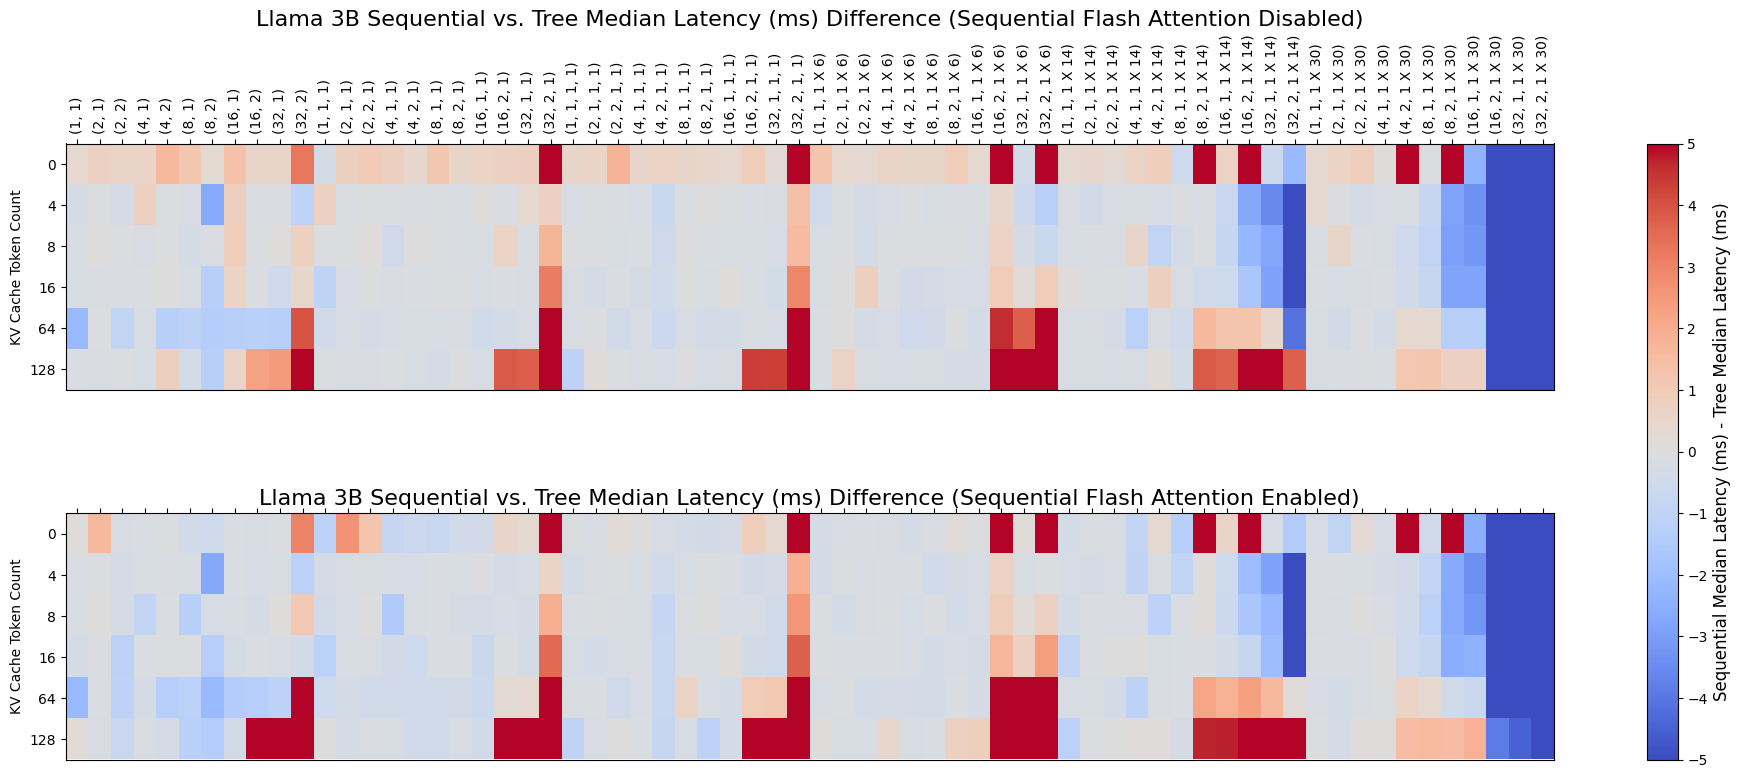

In [65]:
median_attr = "median_time"
p90_attr = "p90_time"
mem_attr = "mem_gb"

time_cap = 0.005 # seconds
mem_cap = 0.3 # GB

seq_pkl_path = "/nlp/u/ananthag/spec/cs349-proj/a6000_results/saved_sequential_3b_2024-06-09_23:59:37.pkl"
seq_flash_pkl_path = "/nlp/u/ananthag/spec/cs349-proj/a6000_results/saved_sequential_flash_3b_2024-06-09_23:42:43.pkl"
tree_pkl_path = "/nlp/u/ananthag/spec/cs349-proj/a6000_results/saved_tree_3b_2024-06-09_23:59:37.pkl"
which_attr = median_attr

construct_graphs(
    seq_dict=pickle.load(open(seq_pkl_path, "rb")),
    seq_flash_dict=pickle.load(open(seq_flash_pkl_path, "rb")),   # Pass None if no flash
    tree_dict=pickle.load(open(tree_pkl_path, "rb")),
    which_attr=median_attr,
    cap=time_cap,
    model_name="Llama 7B"
)

In [14]:
pickle.load(open(tree_pkl_path, "rb"))

{}

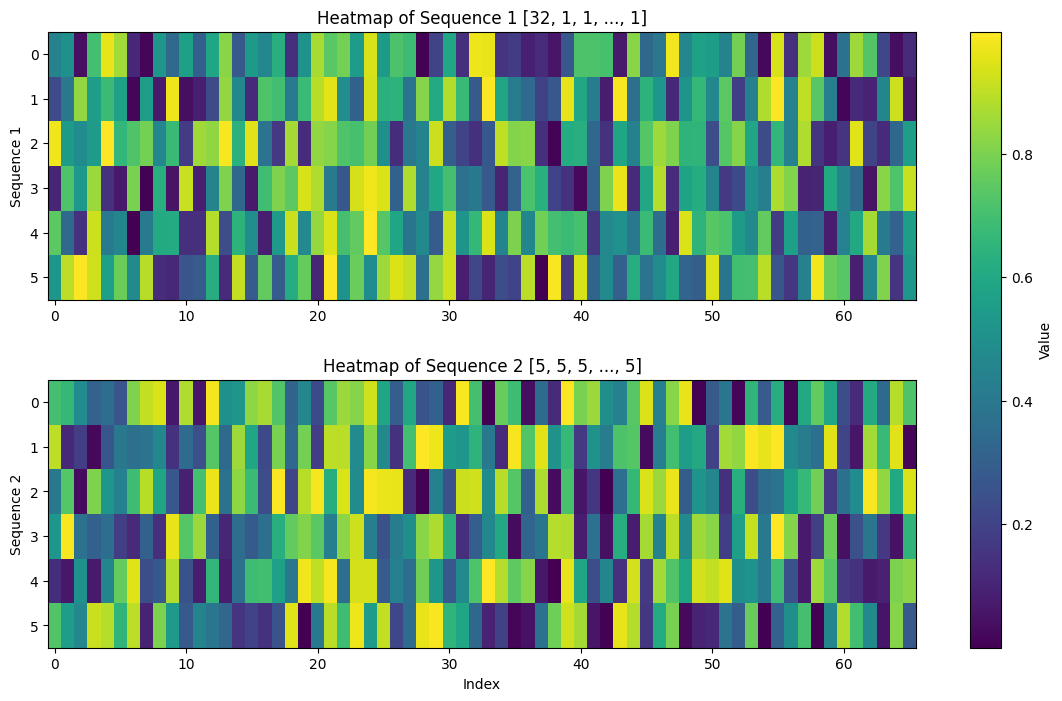

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create two sequences
sequence1 = [32] + [1] * 63
sequence2 = [5] * 64

# Convert to 2D matrices (row vectors)
matrix1 = np.random.rand(6, 66)
matrix2 = np.random.rand(6, 66)

# Create a GridSpec layout with more space
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=.3)  # Adjust hspace for vertical space

# Plot the first heatmap
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(matrix1, cmap='viridis', aspect='auto')
ax1.set_title('Heatmap of Sequence 1 [32, 1, 1, ..., 1]')
ax1.set_ylabel('Sequence 1')

# Plot the second heatmap
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(matrix2, cmap='viridis', aspect='auto')
ax2.set_title('Heatmap of Sequence 2 [5, 5, 5, ..., 5]')
ax2.set_xlabel('Index')
ax2.set_ylabel('Sequence 2')

# Add a single colorbar for both heatmaps
fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', label='Value')

plt.show()
